## [Nematiaram19](https://pubs.acs.org/doi/pdf/10.1021/acs.jpcc.8b11916)
Practical Computation of the Charge Mobility in Molecular Semiconductors Using Transient Localization Theory. T. Nematiaram, S. Ciuchi, X. Xie, S. Fratini and A. Troisi. *J. Phys. Chem. C* **2019**, *123*, 6989-6997.

## [Fratini17](https://www.nature.com/articles/nmat4970)
A Map of High-Mobility Molecular Semiconductors. S. Fratini, S. Ciuchi, D. Mayou, G. T. de Laissardière and A. Troisi. *Nat. Mater.* **2017**, *16*, 998-1002.

In [9]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

## Setup parameters

In [2]:
sizei = sizej = 12
total_size = sizei * sizej * 2
N = 50
T = 290 * 1.38064881e-23 / 4.3597447222071e-18
sigma = 0.5
tau = 5 / 1000 / 27.212
dx = 1
dy = np.sqrt(3)

In [3]:
J = 0.1 / 27.212

In [4]:
position_map = {}
for i in range(sizei):
    for j in range(sizej):
        position_map[(i, j, 0)] = len(position_map)
        position_map[(i, j, 1)] = len(position_map)

## Build the Hamiltonian, $\hat j_x$ and $\hat j_y$
Note that it is not correct to build $\hat x$ and $\hat y$ and use Eq.9 in the paper because this approach can not correctly handle the current at the boundary.

In [5]:
def build_Operators(Ja, Jb, Jc):
    # generate Ja etc according to normal distribution
    def g_Ja():
        return np.random.normal(Ja, np.abs(Ja)*sigma)

    def g_Jb():
        return np.random.normal(Jb, np.abs(Jb)*sigma)

    def g_Jc():
        return np.random.normal(Jc, np.abs(Jc)*sigma)
    
    # terms in the Hamiltonian
    H_terms = []
    for i in range(sizei):
        for j in range(sizej):
            next_i = (i+1) % sizei
            next_j = (j+1) % sizej
            # within unit cell
            H_terms.append( (position_map[i, j, 0], position_map[i, j, 1], g_Jb(), dx/2, dy/2) )
            H_terms.append( (position_map[next_i, j, 0], position_map[i, j, 1], g_Jc(), -dx/2, dy/2) )
            H_terms.append( (position_map[i, next_j, 0], position_map[i, j, 1], g_Jc(), dx/2, -dy/2) )
            H_terms.append( (position_map[next_i, next_j, 0], position_map[i, j, 1], g_Jb(), -dx/2, -dy/2) )
            # horizontal direction
            H_terms.append( (position_map[i, j, 0], position_map[next_i, j, 0], g_Ja(), dx, 0) )
            H_terms.append( (position_map[i, j, 1], position_map[next_i, j, 1], g_Ja(), dx, 0) )
            # vertical direction
            # None
    
    # build operators
    H = np.zeros((total_size, total_size))
    jx_oper = np.zeros((total_size, total_size))
    jy_oper = np.zeros((total_size, total_size))
    for i, j, term, ddx, ddy in H_terms:
        H[i][j] = H[j][i] = term
        jx_oper[i][j] = term * ddx
        jx_oper[j][i] = term * (-ddx)
        jy_oper[i][j] = term * ddy
        jy_oper[j][i] = term * (-ddy)
    return H, jx_oper, jy_oper

## Calculate $L^2$

In [6]:
def calc_L(H, jx_oper, jy_oper):
    evals, evecs = np.linalg.eigh(H) 

    E_n = evals.reshape(-1, 1)
    E_m = evals.reshape(1, -1)

    jx_mat = evecs.T @ jx_oper @ evecs
    jy_mat = evecs.T @ jy_oper @ evecs

    Z = np.exp(E_n / T).sum()

    Lx = np.exp(E_n / T) / Z * (jx_mat ** 2) * ( 2/(tau**2 + (E_m - E_n)**2) )
    Ly = np.exp(E_n / T) / Z * (jy_mat ** 2) * ( 2/(tau**2 + (E_m - E_n)**2) )
    
    return Lx.sum(), Ly.sum()

In [7]:
theta_list = np.linspace(0, np.pi, 20)
mobility_list = []
for theta in theta_list:
    Ja = J * np.cos(theta)
    Jb = Jc = J * np.sin(theta) / np.sqrt(2)
    l2_for_av = []
    for i in tqdm(range(N)):
        Lx, Ly = calc_L(*build_Operators(Ja, Jb, Jc))
        # print(Lx, Ly, (Lx+Ly)/2)
        l2_for_av.append((Lx+Ly)/2)
    mobility_list.append(np.mean(l2_for_av))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.80it/s]


Text(0.5, 0, '$\\theta$')

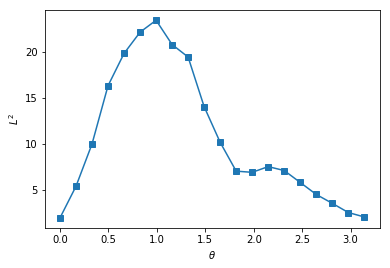

In [13]:
plt.plot(theta_list, mobility_list, marker="s")
plt.ylabel(r"$L^2$")
plt.xlabel(r"$\theta$")